<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:

In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [2]:
import pandas as pd
df = pd.read_csv("train.csv")
print df.shape
df.info()
df.head()

(1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
import matplotlib.pyplot as plt
output = df['trip_duration'].values
plt.hist(output)

(array([1.45864e+06, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000000e+00, 3.5262910e+05, 7.0525720e+05, 1.0578853e+06,
        1.4105134e+06, 1.7631415e+06, 2.1157696e+06, 2.4683977e+06,
        2.8210258e+06, 3.1736539e+06, 3.5262820e+06]),
 <a list of 10 Patch objects>)

In [4]:
import numpy as np
p = np.percentile(output, 95) 
print p

2104.0


Luego de ver el histograma se puede ver que hay algunos datos que contaminan la muestra, luego se calcula donde se junta el 95% de los datos para poder eliminar el 5% superior, para tener una muestra mas limpia.

In [5]:
#eliminar outliers
df = df[(df['trip_duration']<=2104)]

Text(0,0.5,u'Tiempo (min)')

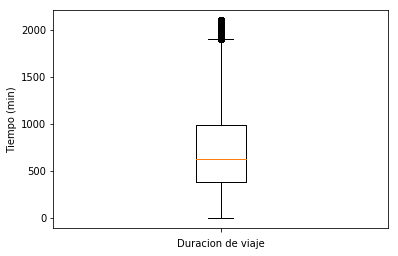

In [6]:
output = df['trip_duration'].values
import matplotlib.pyplot as plt
plt.boxplot([output], sym = 'ko', whis = 1.5)
plt.xticks([1],"", size = 'medium', color = 'k')  # Colocamos las etiquetas para cada distribución
plt.xlabel('Duracion de viaje')
plt.ylabel(u'Tiempo (min)')

En el diagrama caja se puede apreciar que retirar el 5% superior los datos quedan mucho mas trabajables, ya que los datos se comportan de una manera mas homogeneas, esto significa que los datos sobre 2000 aproximadamente no van a poder ser estimado por nuestro modelo, pero esto hara que nuestras predicciones sean mas exactas.

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

Se elimina el 5% superior

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado. 

In [7]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)


In [8]:
df['distancia_viaje_km'].describe(include = 'all')

count    1.385716e+06
mean     2.918843e+00
std      3.303872e+00
min      0.000000e+00
25%      1.198854e+00
50%      1.994340e+00
75%      3.492378e+00
max      1.240910e+03
Name: distancia_viaje_km, dtype: float64

Se eliminan algunas variables que son muy especificas y agregan nuevas variables que nos sirven mucho para el futuro proceso.
Lo datos que se eliminan el id del viaje el cual es unico de cada viaje por lo cual no nos entrega mayor información. También se elimina el id del conductor el cual no influye mucho en la duración del viaje.

Luego se pre-procesa la hora y fecha de recogida y de bajada de los pasajeros, para poder tener que día de la semana es, a que hora, el mes, que estación del año es y se agrega holiday para ver si es feriado o no.

Para finarlizar se pre-procesa la latitud y longitud de recogida y de bajada para calcular la distancia del viaje en km y ver hacia que punto cardinal es hacia donde se dirige(representado en grados).

<div class="alert alert-info"> *Si el proceso demora mucho, lo que se aconseja es realizarlo una vez, guardar los datos en disco y luego leerlos cada vez que se experimenta con los códigos para las pruebas de los modelos de aprendizaje* </div>

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [9]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1385716,)
****************
(970001, 13)
(415715, 13)
*************


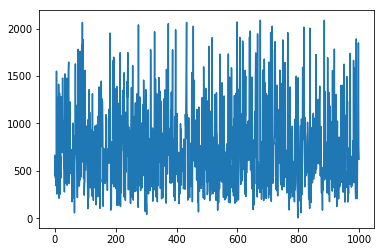

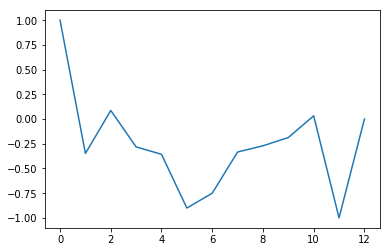

In [10]:
print y.shape
print "****************"
print X_train_scaled.shape
print X_test_scaled.shape
print "*************"

import matplotlib.pyplot as plt
plt.plot(y[0:1000])
plt.show()

import matplotlib.pyplot as plt
plt.plot(X_train_scaled[0:100][9])
plt.show()

El conjunto de entrenaiento tiene 970001 datos y el conjunto de prueba tiene 415715.
Se eligio el RobustScaler para normalizar los datos, ya que este esta basado en los percentiles, por lo cual no se ve afectado por los pocos datos que estan fuera del margen regular. Los datos tienen dimensionalidad 13

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

In [11]:
import math
#fuente: 
# https://stackoverflow.com/questions/46202223/root-mean-log-squared-error-issue-with-scitkit-learn-ensemble-gradientboostingre
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()

In [12]:
print X_train_scaled.shape
print y_train.shape
print "***"

(970001, 13)
(970001,)
***


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = baseline_model()
model.fit(X_train_scaled,y_train, epochs=25) 
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y_train, model.predict(X_train_scaled)))
print("MAE on train: ",mean_absolute_error(y_test, model.predict(X_test_scaled)))
print ("ERROR RMSLE de training: ", rmsle(y_train,model.predict(X_train_scaled)))
print ("ERROR RMSLE de test: ", rmsle(y_test,model.predict(X_test_scaled)))

/home/maldos/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/25
970001/970001 [==============================] - 118s 122us/step - loss: 191808.8726
Epoch 2/25
970001/970001 [==============================] - 112s 115us/step - loss: 133037.5058
Epoch 3/25
970001/970001 [==============================] - 116s 120us/step - loss: 126485.2575
Epoch 4/25
970001/970001 [==============================] - 118s 121us/step - loss: 118422.9047
Epoch 5/25
970001/970001 [==============================] - 119s 123us/step - loss: 112160.9081
Epoch 6/25
970001/970001 [==============================] - 134s 138us/step - loss: 105517.7845
Epoch 7/25
970001/970001 [==============================] - 134s 138us/step - loss: 100985.6624
Epoch 8/25
970001/970001 [==============================] - 105s 108us/step - loss: 97492.8377
Epoch 9/25
970001/970001 [==============================] - 109s 112us/step - loss: 92305.0048
Epoch 10/25
970001/970001 [==============================] - 138s 142us/step - loss: 91001.7202
Epoch 11/25
970001/970001 [===============

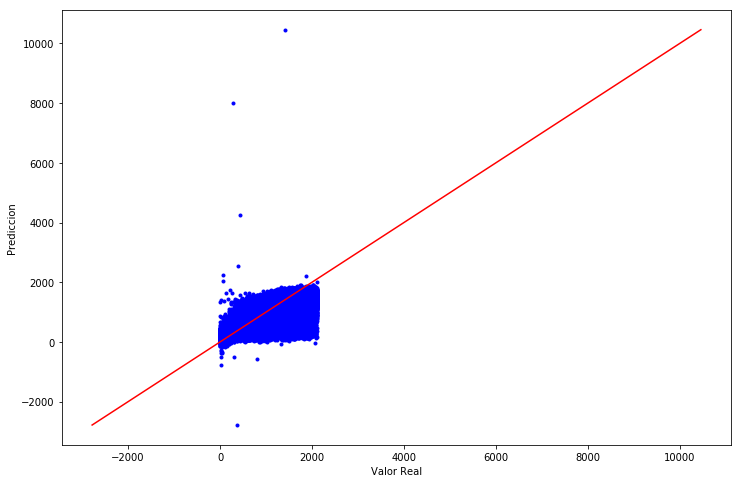

In [14]:
graficar_predicciones(y_test,model.predict(X_test_scaled))

In [15]:
from sklearn import linear_model
def linearMODEL(X_train,y_train):
    regr = linear_model.Ridge()
#     regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    return regr
model = linearMODEL(X_train_scaled,y_train) 
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y_train, model.predict(X_train_scaled)))
print("MAE on test: ",mean_absolute_error(y_test, model.predict(X_test_scaled)))
print ("ERROR RMSLE de training: ", rmsle(y_train,model.predict(X_train_scaled)))
print ("ERROR RMSLE de test: ", rmsle(y_test,model.predict(X_test_scaled)))

('MAE on train: ', 264.32261246954573)
('MAE on test: ', 263.7074810616683)
('ERROR RMSLE de training: ', 0.6021249536290607)
('ERROR RMSLE de test: ', 0.603479351254775)


Nos damos cuenta  que el error RMSLE es considerablemente menor en la red neuronal que en el Ridge, pero debido al largo tiempo de trabajo de redes neuronales trabajaremos con Ridge.

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

Nosotros esperamos que el modelo no tenga total precisión, pero que si tenga un valor cercano al esperado. El resultado en cambio muestra lo que esperabamos, pero con unos cuantos datos que toman un valor totalmente distinto de lo esperado, esto se debe a los datos atípicos que pueden aparecer en el dataset de prueba, los cuales fueron eliminados en nuestro dataset de entrenamiento, pór lo cual mas adelante se buscara eliminar estos datos, ya que nuestro programa no esta entrenado para acertar en este tipo de casos.

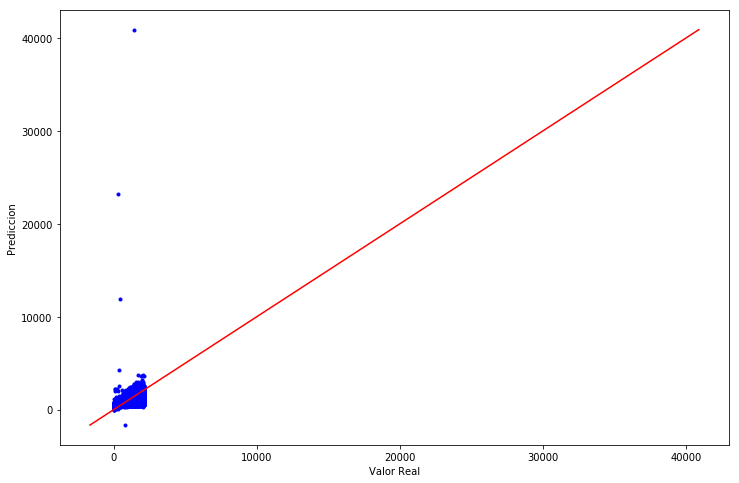

In [16]:
graficar_predicciones(y_test,model.predict(X_test_scaled))

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

('MAE on train: ', 264.3121172312422)
('MAE on test: ', 263.6981763620718)
('ERROR RMSLE de training: ', 0.6024034034405223)
('ERROR RMSLE de test: ', 0.6037543782141468)


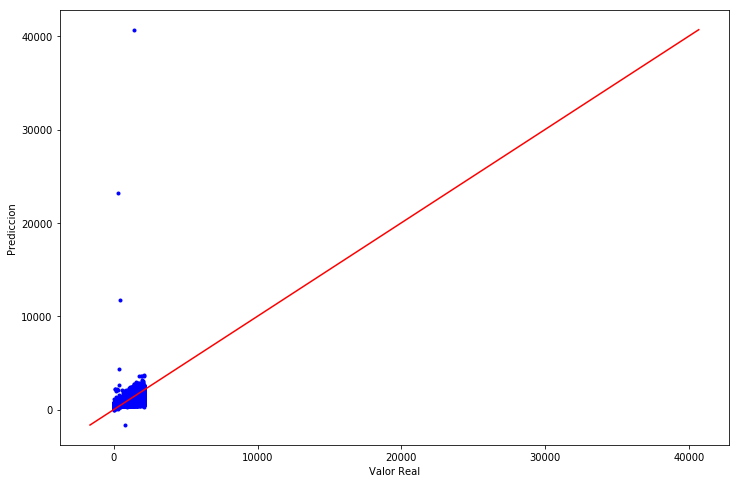

In [17]:
from sklearn import linear_model
def linearMODEL(X_train,y_train):
    regr = linear_model.Ridge(alpha=10000)
#     regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    return regr
model = linearMODEL(X_train_scaled,y_train) 
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y_train, model.predict(X_train_scaled)))
print("MAE on test: ",mean_absolute_error(y_test, model.predict(X_test_scaled)))
print ("ERROR RMSLE de training: ", rmsle(y_train,model.predict(X_train_scaled)))
print ("ERROR RMSLE de test: ", rmsle(y_test,model.predict(X_test_scaled)))
graficar_predicciones(y_test,model.predict(X_test_scaled))

En este caso se intento cambiar el alpha del modelo y no se tuvo mucho exito.

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

In [18]:
print X_train.shape
#ordenes de labels por columna: marcamos los que son relevantes a nuestros ojos
#0=>passenger_count [NO RELEVANTE]
#1=>pickup_longitude [RELEVANTE] 
#2=>pickup_latitude [RELEVANTE]
#3=>dropoff_longitude [RELEVANTE]
#4=>dropoff_latitude [RELEVANTE]
#5=>hour [RELEVANTE]
#6=>cday [RELEVANTE]
#7=>month [RELEVANTE]
#8=>distancia_viaje [NO RELEVANTE]
#9=>distancia_viaje_km [RELEVANTE]
#10=>grado_direccion [RELEVANTE]
#11=>season [RELEVANTE]
#12=>holiday [RELEVANTE]

(970001, 13)


In [19]:
def quitarMuyVeloces(X_train,Y_train):
    lista = []
    for i in range(X_train.shape[0]):
        if ((1000*X_train[i][9]/Y_train[i]) >= 50):
            lista.append(i)
    print lista
    salto=1
    for i in range(len(lista), -1, -1):
        if (salto==1):
            salto=0
            continue
        else:
            X_train = np.delete(X_train, lista[i], 0)  # delete second row of A
            Y_train = np.delete(Y_train, lista[i], 0)  # delete second row of A
    return X_train,Y_train

#a continuación quitamos las columnas de valores de passenger_count y distancia_viaje de los datos X_train y X_test
def modificacionDeInputs(X_train,X_test):
    X_train = np.delete(X_train, 8, 1)
    X_train = np.delete(X_train, 0, 1)
    X_test = np.delete(X_test, 8, 1)
    X_test = np.delete(X_test, 0, 1)  
    return X_train,X_test

    

In [20]:
print X_train.shape
X_trainModificado, Y_trainModificado = quitarMuyVeloces(X_train,y_train)
X_testModificado, Y_testModificado = X_test,y_test
# X_trainModificado, X_testModificado=modificacionDeInputs(X_train,X_test)
# print Y_trainModificado.shape
print X_trainModificado.shape

(970001, 13)
[21741, 25285, 26408, 28550, 31470, 38406, 51544, 55473, 76657, 80201, 90704, 138618, 169237, 169444, 178146, 179108, 283090, 285297, 301436, 316152, 328185, 380254, 388117, 417390, 419755, 456354, 464263, 489909, 494038, 519046, 543735, 546720, 551495, 600683, 606264, 607731, 624742, 629164, 663192, 676516, 687688, 743557, 762196, 792796, 808317, 823645, 851897, 903705, 931910]
(969952, 13)


In [21]:
print X_trainModificado.shape
X_trainMod, Y_trainMod = quitarMuyVeloces(X_trainModificado,Y_trainModificado)
X_testMod, Y_testMod = X_testModificado,Y_testModificado
# X_trainModificado, X_testModificado=modificacionDeInputs(X_train,X_test)
# print Y_trainModificado.shape
print X_trainMod.shape

(969952, 13)
[]
(969952, 13)


In [22]:
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_trainModificado)
X_trainModificado_scaled = scaler.transform(X_trainModificado)
X_testModificado_scaled = scaler.transform(X_testModificado)

('MAE on train: ', 246.3254060404242)
('MAE on test: ', 246.12448386660796)
('ERROR RMSLE de training: ', 0.5594523015035078)
('ERROR RMSLE de test: ', 0.5614898930901785)


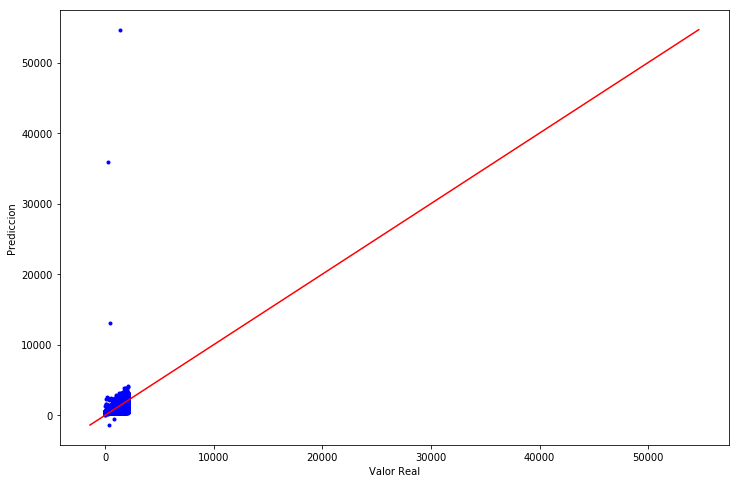

In [23]:
from sklearn import linear_model
def linearMODEL(X_train,y_train):
    regr = linear_model.Ridge(alpha=10000)
    regr.fit(X_train, y_train)
    return regr

model = linearMODEL(X_trainModificado_scaled,Y_trainModificado) 
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(Y_trainModificado, model.predict(X_trainModificado_scaled)))
print("MAE on test: ",mean_absolute_error(Y_testModificado, model.predict(X_testModificado_scaled)))
print ("ERROR RMSLE de training: ", rmsle(Y_trainModificado,model.predict(X_trainModificado_scaled)))
print ("ERROR RMSLE de test: ", rmsle(Y_testModificado,model.predict(X_testModificado_scaled)))
graficar_predicciones(Y_testModificado,model.predict(X_testModificado_scaled))

Para mejorar el modelo se  vieron cuales variables considerabamos relevantes y cuales no, para poder precendir de estos. También se utilizo un metodo para eliminar todos los datos que tuvieran una velocidad promedio de 50km/h, ya que es irrealista que un auto se mueva a esa velocidad en nueva york, a menos que este andando en autopista constantemente y eso simplemente nos contamina nuestro dataset.

Podemos ver que con los cambios hechos se eliminaron los datos atípicos y se logro reducir un poco el RMSLE, pero no todo lo deseado.

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.

In [24]:
#import matplotlib.pyplot as plt
#output = abs(X_train[0:100][9])
#plt.hist(output)

In [25]:
YTRAIN=Y_trainModificado
YTEST=Y_testModificado
XTRAIN=X_trainModificado_scaled
XTEST=X_testModificado_scaled
from sklearn import linear_model
def linearMODEL(X,y):
    regr = linear_model.Ridge(alpha=10000)
    regr.fit(X, y)
    return regr

"""define your transformation!!"""
#ultimas entradas: Y_testModificado, X_testModificado_scaled
#ultimas entradas: Y_trainModificado, X_trainModificado_scaled
import math
print type(YTRAIN[0])
def transformar(yTarget):
    array=[]
    r=0
    for i in range (yTarget.shape[0]):
        r=math.sqrt(yTarget[i])
        array.append(r)
    return array
def destransformar(valor):
    for i in range (valor.shape[0]):
        valor[i]=valor[i]*valor[i]
    return valor 

model = linearMODEL(XTRAIN,transformar(YTRAIN))

print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(XTRAIN)),YTRAIN)
print "ERROR RMSLE de test: ", rmsle(destransformar(model.predict(XTEST)),YTEST)
#################################################################################################
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = baseline_model()
model.fit(XTRAIN,transformar(YTRAIN), epochs=25) 
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(YTRAIN, destransformar(model.predict(XTRAIN))))
print("MAE on train: ",mean_absolute_error(YTEST, destransformar(model.predict(XTEST))))
print ("ERROR RMSLE de training: ", rmsle(YTRAIN,destransformar(model.predict(XTRAIN))))
print ("ERROR RMSLE de test: ", rmsle(YTEST,destransformar(model.predict(XTEST))))

<type 'numpy.int64'>
ERROR RMSLE de training:  0.5525472294349018
ERROR RMSLE de test:  0.5546543210525444
Epoch 1/25
969952/969952 [==============================] - 114s 117us/step - loss: 50.1429
Epoch 2/25
969952/969952 [==============================] - 127s 131us/step - loss: 26.0173
Epoch 3/25
969952/969952 [==============================] - 127s 131us/step - loss: 28.5003
Epoch 4/25
969952/969952 [==============================] - 128s 132us/step - loss: 25.5258
Epoch 5/25
969952/969952 [==============================] - 131s 135us/step - loss: 25.2311
Epoch 6/25
969952/969952 [==============================] - 136s 140us/step - loss: 25.4056
Epoch 7/25
969952/969952 [==============================] - 135s 139us/step - loss: 25.2333
Epoch 8/25
969952/969952 [==============================] - 138s 143us/step - loss: 28.5799
Epoch 9/25
969952/969952 [==============================] - 140s 144us/step - loss: 24.7143
Epoch 10/25
969952/969952 [==============================] - 142s

Para lograr llegar a menos de 0.5 RMSLE se utilizo la raiz cuadrada al output y también se tuvo que utilizar el metodo de la red neuronal, el cual consume muchisimo tiempo.

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.

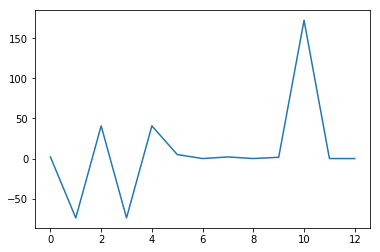

In [26]:
import matplotlib.pyplot as plt
plt.plot(X_train[0:100][9])
plt.show()

In [27]:
#for i in range (X_trainModificado.shape[0]):
#    X_trainModificado[i][9]=abs(X_trainModificado[i][9])
a=0
for i in range (X_trainModificado.shape[0]):
    a+=X_trainModificado[i][9]
prom=a/X_trainModificado.shape[0]
print prom

2.917024502369802


In [28]:
X_train_sup=[]
y_train_sup=[]
X_train_inf=[]
y_train_inf=[]
for i in range (X_trainModificado.shape[0]):
    if X_trainModificado[i][9] > prom:
        X_train_sup.append(X_trainModificado[i])
        y_train_sup.append(Y_trainModificado[i])
    if X_trainModificado[i][9] <= prom:
        X_train_inf.append(X_trainModificado[i])
        y_train_inf.append(Y_trainModificado[i])
X_train_sup = np.asarray(X_train_sup)
y_train_sup = np.asarray(y_train_sup)
X_train_inf = np.asarray(X_train_inf)
y_train_inf = np.asarray(y_train_inf)

In [29]:
X_test_sup=[]
y_test_sup=[]
X_test_inf=[]
y_test_inf=[]
for i in range (X_testModificado.shape[0]):
    if X_testModificado[i][9] > prom:
        X_test_sup.append(X_testModificado[i])
        y_test_sup.append(Y_testModificado[i])
    if X_testModificado[i][9] <= prom:
        X_test_inf.append(X_testModificado[i])
        y_test_inf.append(Y_testModificado[i])
        
from sklearn import linear_model
def linearInfMODEL(X_train_inf,y_train_inf):
    regr = linear_model.Ridge(alpha=100000)
    regr.fit(X_train_inf, y_train_inf)
    return regr
def linearSupMODEL(X_train_sup,y_train_sup):
    regr = linear_model.Ridge(alpha=100000)
    regr.fit(X_train_sup, y_train_sup)
    return regr

X_test_sup = np.asarray(X_test_sup)
y_test_sup = np.asarray(y_test_sup)
X_test_inf = np.asarray(X_test_inf)
y_test_inf = np.asarray(y_test_inf)


(310332, 13)
(310332,)
(659620, 13)
(659620,)
('MAE on train: ', 284.4081263645262)
('MAE on test: ', 284.4081263645262)
('ERROR RMSLE de training: ', 0.3315404275411462)
('ERROR RMSLE de test: ', 0.3315404275411462)
('MAE on train: ', 188.42199268100921)
('MAE on test: ', 188.42199268100921)
('ERROR RMSLE de training: ', 0.5324077247393494)
('ERROR RMSLE de test: ', 0.5324077247393494)


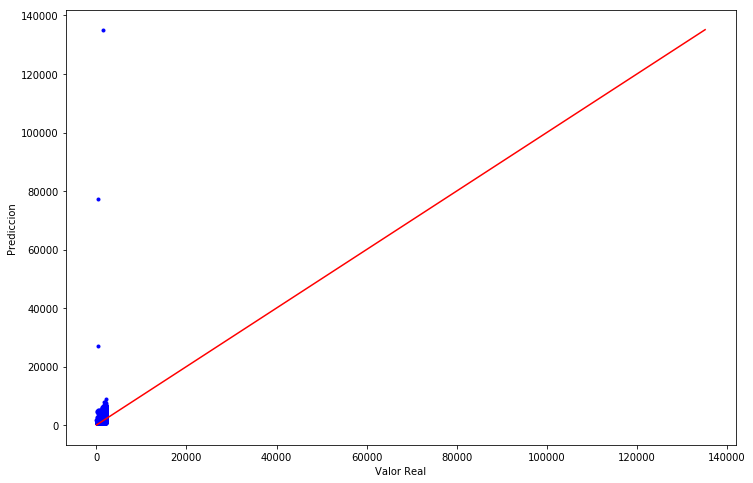

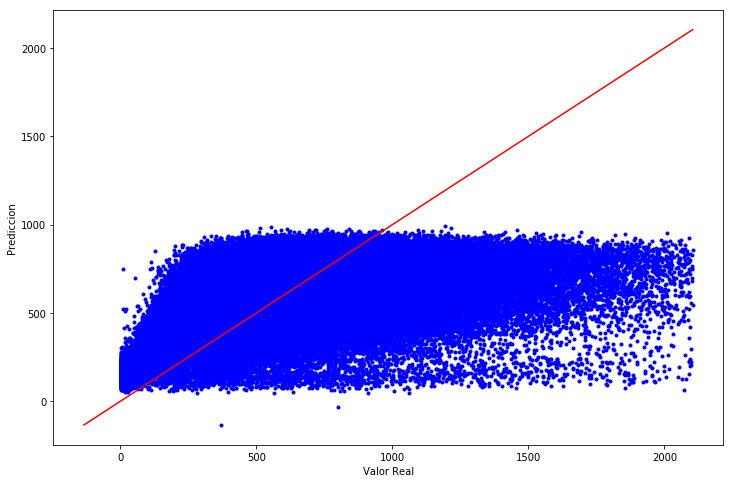

In [30]:
modelSup=linearSupMODEL(X_train_sup,y_train_sup)
modelInf=linear_model.Ridge(alpha=10000)
modelInf.fit(X_train_inf,y_train_inf)
print X_train_sup.shape
print y_train_sup.shape
print X_train_inf.shape
print y_train_inf.shape
#ahora usamos los valores X_test, separados previamente en X_test_sup y X_test_inf
#X_test_sup prediciendo y_test_sup
print("MAE on train: ",mean_absolute_error(y_test_sup, modelSup.predict(X_test_sup)))
print("MAE on test: ",mean_absolute_error(y_test_sup, modelSup.predict(X_test_sup)))
print ("ERROR RMSLE de training: ", rmsle(y_test_sup,modelSup.predict(X_test_sup)))
print ("ERROR RMSLE de test: ", rmsle(y_test_sup,modelSup.predict(X_test_sup)))

#X_test_inf prediciendo y_test_inf
print("MAE on train: ",mean_absolute_error(y_test_inf, modelInf.predict(X_test_inf)))
print("MAE on test: ",mean_absolute_error(y_test_inf, modelInf.predict(X_test_inf)))
print ("ERROR RMSLE de training: ", rmsle(y_test_inf,modelInf.predict(X_test_inf)))
print ("ERROR RMSLE de test: ", rmsle(y_test_inf,modelInf.predict(X_test_inf)))
graficar_predicciones(y_test_sup,modelInf.predict(X_test_sup))
graficar_predicciones(y_test_inf,modelInf.predict(X_test_inf))



Con este método podemos ver que el RMSLE de los valores superiores al promedio baja considerablemente y esto se podria deber a que mientras mas largo el viaje mas homogeneo el tiempo que te lleva realizarlo. Mientras que los viajes que son mas cortos que el promedio tienen un alza en el RMSLE, debido a lo variado de la duración de los tiempos de viaje.